In [1]:
import os
import sys
sys.path.append(os.path.abspath("../"))

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

import math
from src.utils import reload_script
import warnings

from models_src.Support import LRCallback
from models_src.UNet_model import UNet
from models_src.Metrics import WeightedF12D, LossBasedMetric
import models_src.VecModels as vcm

from models_src.VecDataset import MultishapeMapGenerator, DatasetGenerator, blur_img, op_pixel_similarity
from models_src.fft_lib import xy_coords, decode1Dcoords
from models_src.Trainer import TrainingProcessor2
from Fourier.datasets.generator_cfg import generator_cfg
%matplotlib inline

from models_src.Attn_variations import SqueezeImg, UnSqueezeImg
from models_src.DETR import FFN, HeadsPermuter

print(tf.config.list_physical_devices('GPU'))

2024-07-18 14:49:36.731668: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-18 14:49:36.893313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 14:49:37.003175: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 14:49:37.003916: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-18 14:49:37.140497: I tensorflow/core/platform/cpu_feature_gua

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-07-18 14:49:45.930031: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 14:49:46.106592: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 14:49:46.106661: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
reload_script('models_src.VecModels')

In [24]:
import mlflow

mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/fzzyfoxx@gmail.com/pixel_similarity_dot")
mlflow.tensorflow.autolog(log_datasets=False, log_models=True, disable=False )

2024/07/18 14:53:03 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [4]:
class cfg:
    train_batch_size = 32
    val_batch_size = 256
    test_batch_size = 8
    ds_path = './datasets/pixel_similarity'

# Dataset

In [5]:
msmg = MultishapeMapGenerator(['img', 'angle_label', 'center_vec_label', 'line_label', 'shape_label', 'thickness_label', 'pattern_masks', 'shape_masks', 'vecs_masks', 'bbox_masks', 'vecs', 'bboxes', 'vecs_mask', 'bbox_mask', 'shape_thickness'],
                              generator_cfg.size, 
                              **generator_cfg.drawing_args, 
                              patterns_prob=generator_cfg.patterns_prob, 
                              line_args=generator_cfg.line_args, 
                              shape_args=generator_cfg.shape_args, 
                              line_filled_args=generator_cfg.line_filled_args, 
                              polyline_args=generator_cfg.polyline_args, 
                              linear_shapes_args=generator_cfg.linear_shapes_args, 
                              spreaded_shapes_args=generator_cfg.spreaded_shapes_args
                              )


2024-07-18 14:49:47.524614: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 14:49:47.524952: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 14:49:47.525026: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 14:49:47.816190: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 14:49:47.816376: I external/local_xla/xla/stream_executor

In [6]:
dg = DatasetGenerator(msmg, 
                      ds_path='./datasets/pixel_similarity', 
                      fold_size=512*4, 
                      parallel_calls=4, 
                      padded_batch=True, 
                      output_filter=['img','pattern_masks'],
                      preprocess_funcs=[(blur_img, {'blur_ratio_range': (0.1, 0.6), 'kernel_size': 3, 'color_rand_range': 0.1}, True),
                                        (op_pixel_similarity, {}, True)]
                      )

In [7]:
ds, train_steps = dg.dataset(from_saved=True, batch_size=cfg.train_batch_size, validation=False, val_idxs=[0], shuffle_buffer_size=32)
val_ds, val_steps = dg.dataset(from_saved=True, batch_size=cfg.val_batch_size, validation=True, val_idxs=[0])
test_ds, test_steps = dg.dataset(from_saved=True, batch_size=cfg.test_batch_size, validation=True, val_idxs=[0])
ds_iter = iter(ds)
val_iter = iter(val_ds)
test_iter = iter(test_ds)

# Model

### args

In [8]:
backbone_args = {
    'input_shape': (32,32,3),
    'init_filters_power': 6,
    'levels': 3,
    'level_convs': 4,
    'init_dropout': 0.0,
    'dropout': 0.3,
    'batch_normalization': True,
    'name': 'PxFeaturesUnet'
}

backbone_generator = vcm.pixel_features_unet

model_args = {
    'backbone_args': backbone_args,
    'backbone_generator': backbone_generator,
    'backbone_weights_path': './final_state/PxFeaturesUnet/e45_ps',
    'backbone_trainable': False,
    'backbone_last_layer': 'Up-Conv_2',
    'backbone_init_layer': 'Batch-Normalization',
    'color_embs_num': 32,
    'color_embs_mid_layers': 3,
    'conv_num': 3,
    'conv_dim': 64,
    'attn_dim': 128,
    'heads_num': 5,
    'pre_attn_ffn_mid_layers': 2,
    'dropout': 0.2,
    'use_heads': False,
    'name': 'PxSimDot'
}

In [9]:
class DotSimilarityLayer(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-6, **kwargs):
        super().__init__(**kwargs)

        self.e = epsilon

    def call(self, inputs):
        x = tf.matmul(inputs, inputs, transpose_b=True)
        x = tf.nn.softmax(x, axis=-1)
        max_sim = tf.reduce_max(x, axis=-1, keepdims=True) + self.e
        x = x/max_sim

        return x
    
class PixelSimilarityF1(tf.keras.metrics.Metric):
    def __init__(self, skip_first_pattern=True, threshold=0.5, name='F1', **kwargs):
        super(PixelSimilarityF1, self).__init__(name=name, **kwargs)

        self.f1 = tf.keras.metrics.F1Score(threshold=threshold, average='micro')
        self.flatten = tf.keras.layers.Flatten()
        self.score = self.add_weight(name='f1', initializer='zeros')
        self.iterations = self.add_weight(name='iters', initializer='zeros')
        self.threshold = threshold

        self.squeeze_img = SqueezeImg()
        self.squeeze_mask = SqueezeImg()
        self.skip_first = skip_first_pattern

    def get_config(self):
        return {**super().get_config(), 
                'threshold': self.threshold, 
                'skip_first_pattern': self.skip_first}

    def update_state(self, y_true, y_pred, sample_weight=None):

        if self.skip_first:
            y_true = y_true[:,1:]

        y_true = tf.squeeze(self.squeeze_img(y_true), axis=-1)
        y_true = tf.matmul(y_true, y_true, transpose_a=True)
        y_pred = y_pred*tf.reduce_max(y_true, axis=-1, keepdims=True)

        self.score.assign_add(self.f1(self.flatten(y_true), self.flatten(y_pred)))
        self.iterations.assign_add(1.0)

    def result(self):
        return self.score/self.iterations
    
class WeightedPixelCrossSimilarityCrossentropy(tf.keras.losses.Loss):
    def __init__(self, label_smoothing=0.0,  name='PCS', reduction=tf.keras.losses.Reduction.AUTO, **kwargs):
        super().__init__(name=name, reduction=reduction, **kwargs)

        self.squeeze_img = SqueezeImg()
        self.label_smoothing = label_smoothing

    def get_config(self):
        return {
            'name': self.name,
            'label_smoothing': self.label_smoothing,
        }
    
    def call(self, y_true, y_pred):
        y_true = tf.squeeze(self.squeeze_img(y_true), axis=-1) #[B,P,HW]

        pattern_sums = tf.reduce_sum(y_true, axis=-1, keepdims=True)+1e-6 #[B,P,1]
        weights = tf.reduce_sum(y_true/pattern_sums, axis=-2) #[B,HW]
        weights_denom = tf.reduce_sum(weights, axis=-1, keepdims=True) #[B,1]
        weights = weights/weights_denom #[B,HW]

        y_true = tf.matmul(y_true, y_true, transpose_a=True) #[B,HW,HW]

        loss_value = tf.keras.losses.binary_crossentropy(y_true, y_pred, label_smoothing=self.label_smoothing, axis=-1) #[B,HW]
        loss_value = tf.reduce_sum(loss_value*weights, axis=-1) #[B]

        return loss_value

In [10]:
def backbone_based_pixel_similarity_dot_model(
        backbone_args,
        backbone_generator,
        backbone_weights_path,
        backbone_trainable,
        backbone_last_layer,
        backbone_init_layer,
        color_embs_num,
        color_embs_mid_layers,
        conv_num,
        conv_dim,
        attn_dim,
        heads_num,
        use_heads,
        pre_attn_ffn_mid_layers,
        dropout,
        name='PxSimDot'
        ):
    
    conv_dim = attn_dim//2
    
    backbone_model = backbone_generator(**backbone_args)
    if backbone_weights_path is not None:
        backbone_model.load_weights(f'./{backbone_weights_path}.weights.h5')

    backbone_model.trainable = backbone_trainable
    inputs = backbone_model.input
    memory = backbone_model.get_layer(backbone_last_layer).output
    normed_img = backbone_model.get_layer(backbone_init_layer).output

    normed_img = SqueezeImg()(normed_img)
    color_embs_map = FFN(mid_layers=color_embs_mid_layers, mid_units=color_embs_num*2, output_units=color_embs_num, dropout=dropout, activation='relu')(normed_img)

    memory = tf.keras.layers.Conv2D(conv_dim, kernel_size=1, padding='same', activation='relu', name='Conv_init')(memory)
    x = memory
    for i in range(conv_num):
        x = tf.keras.layers.Conv2D(conv_dim, kernel_size=3, padding='same', activation='relu', name=f'Conv_{i+1}')(x)

    x = tf.keras.layers.Concatenate(name='Concat_Memory')([x, memory])
    x = SqueezeImg()(x)
    x = FFN(mid_layers=pre_attn_ffn_mid_layers, mid_units=attn_dim*2, output_units=attn_dim, dropout=dropout, activation='relu', name='features_FFN')(x)
    x = tf.keras.layers.Concatenate(name='Concat_Color_Embs')([x, color_embs_map])

    if use_heads:
        x = HeadsPermuter(num_heads=heads_num, emb_dim=(attn_dim+color_embs_num)//heads_num, name='Heads_Permute')(x)
        x = tf.keras.layers.LayerNormalization(axis=-1, name='Heads_Norm')(x)
        x = HeadsPermuter(num_heads=heads_num, emb_dim=(attn_dim+color_embs_num)//heads_num, reverse=True, name='Heads_Unpermute')(x)
    else:
        x = tf.keras.layers.LayerNormalization(axis=-1, name='Norm')(x)
    out = DotSimilarityLayer(epsilon=1e-6, name='Dot_Similarity')(x)

    return tf.keras.Model(inputs, out, name=name)

### compile

In [25]:
model_generator = backbone_based_pixel_similarity_dot_model

compile_args = {
    'optimizer': tf.keras.optimizers.Adam(1e-3),
    'loss': {'Dot_Similarity': vcm.PixelCrossSimilarityCrossentropy(label_smoothing=0.1, axis=-1, reduction='sum_over_batch_size')},
    #'loss': {'Dot_Similarity': WeightedPixelCrossSimilarityCrossentropy(label_smoothing=0.1, reduction='sum_over_batch_size')},
    #'metrics': {'Dot_Similarity': PixelSimilarityF1(skip_first_pattern=True, threshold=0.5)}
}

# Training

In [26]:
trainer = TrainingProcessor2(cfg)
trainer.load_dataset(ds, train_steps, val_ds, val_steps)
trainer.load_model_generator(model_generator)

In [27]:
trainer.compile_model(
    model_args = model_args,
    print_summary = True,
    **compile_args
)

Model: "PxSimDot"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ unet_input          │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch-Normalization │ (None, 32, 32, 3) │         12 │ unet_input[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down-Conv_1         │ [(None, 16, 16,   │    112,576 │ Batch-Normalizat… │
│ (UNetConvBlock)     │ 64), (None, 32,   │            │                   │
│                     │ 32, 64)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down-Conv_2         │ [(None, 8, 8,     │    516,608 │ Down-Conv_1[0][0] │
│ (UNetConvBlock)     │ 128), (None, 16,  │            │                   │
│                     │ 16, 128)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down-Conv_3         │ [(None, 4, 4,     │  2,065,408 │ Down-Conv_2[0][0] │
│ (UNetConvBlock)     │ 256), (None, 8,   │            │                   │
│                     │ 8, 256)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Up-Conv_1           │ (None, 16, 16,    │    868,992 │ Down-Conv_3[0][1… │
│ (UNetUpConvBlock)   │ 128)              │            │ Down-Conv_2[0][1] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Up-Conv_2           │ (None, 32, 32,    │    217,408 │ Up-Conv_1[0][0],  │
│ (UNetUpConvBlock)   │ 64)               │            │ Down-Conv_1[0][1] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_init (Conv2D)  │ (None, 32, 32,    │      4,160 │ Up-Conv_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1 (Conv2D)     │ (None, 32, 32,    │     36,928 │ Conv_init[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_2 (Conv2D)     │ (None, 32, 32,    │     36,928 │ Conv_1[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_3 (Conv2D)     │ (None, 32, 32,    │     36,928 │ Conv_2[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concat_Memory       │ (None, 32, 32,    │          0 │ Conv_3[0][0],     │
│ (Concatenate)       │ 128)              │            │ Conv_init[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_img_17      │ (None, 1024, 128) │          0 │ Concat_Memory[0]… │
│ (SqueezeImg)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_img_16      │ (None, 1024, 3)   │          0 │ Batch-Normalizat… │
│ (SqueezeImg)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_FFN (FFN)  │ (None, 1024, 128) │    131,712 │ squeeze_img_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_1 (FFN)         │ (None, 1024, 32)  │     10,656 │ squeeze_img_16[0… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,038,636 (15.41 MB)

 Trainable params: 257,632 (1006.38 KB)

 Non-trainable params: 3,781,004 (14.42 MB)

None


## train

In [28]:
trainer.train_model(
    epochs = 7,
    callbacks = [LRCallback(warmup_lr=1e-5, warmup_epochs=0, decay_ratio=0.9)],
    log = True,
    export_final_state = True,
    export_model = False
)

MLflow run: unique-bat-307


Epoch 1/7


I0000 00:00:1721307227.639909   46243 service.cc:145] XLA service 0x7f10c4018c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721307227.641082   46243 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-07-18 14:53:47.797647: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1721307233.132439   48821 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1721307233.693110   48823 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1721307234.060128   48820 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_ge

510/512 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.4107

I0000 00:00:1721307260.688119   49305 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1721307261.022138   49310 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1721307262.062328   49306 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1721307262.221653   49299 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 24 bytes spill stores, 24 bytes spill loads



512/512 ━━━━━━━━━━━━━━━━━━━━ 44s 43ms/step - loss: 2.4027 - val_loss: 0.3485 - learning_rate: 0.0010
Epoch 2/7
512/512 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.3396 - val_loss: 0.2963 - learning_rate: 9.0000e-04
Epoch 3/7
512/512 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.3015 - val_loss: 0.2871 - learning_rate: 8.1000e-04
Epoch 4/7
512/512 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.2906 - val_loss: 0.2775 - learning_rate: 7.2900e-04
Epoch 5/7
512/512 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.2847 - val_loss: 0.2829 - learning_rate: 6.5610e-04
Epoch 6/7
512/512 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.2809 - val_loss: 0.2731 - learning_rate: 5.9049e-04
Epoch 7/7
512/512 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.2782 - val_loss: 0.2774 - learning_rate: 5.3144e-04


2024-07-18 14:55:29.037026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
I0000 00:00:1721307331.626849   50162 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4', 140 bytes spill stores, 140 bytes spill loads

I0000 00:00:1721307331.730132   50161 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1721307331.924226   50160 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1721307332.393684   50156 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1721307332.424392   50155 asm_compiler.cc:369] ptxas warning : Registers 

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


2024/07/18 14:55:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/tmp/tmpitf5qc98/model/data/model.


In [24]:
tf.config.experimental.get_memory_info('GPU:0')['peak']*1e-6

2599.2450559999997

In [29]:
f1_metric = PixelSimilarityF1(skip_first_pattern=True, threshold=0.5)
pb = tf.keras.utils.Progbar(test_steps, stateful_metrics=['F1', 'memory_usage'])

for i in range(test_steps):
    img, labels = next(test_iter)
    preds = trainer.model(img, training=False)
    f1_metric.update_state(labels, preds)
    pb.update(i+1, values=[('F1', f1_metric.result()), ('memory_usage', tf.config.experimental.get_memory_info('GPU:0')['current']*1e-6)])

256/256 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - F1: 0.8101 - memory_usage: 121.6333


In [30]:
run_id = mlflow.search_runs(order_by=['start_time DESC']).iloc[0].run_id
with mlflow.start_run(run_id=run_id):
    mlflow.log_metric('F1', f1_metric.result().numpy())

In [ ]:
mlflow.end_run(status="KILLED")

## load model

In [49]:
trainer.save_temp_weights('./final_state', filename='e7_weighted', use_model_name=True)

In [31]:
trainer.load_temp_weights('final_state/PxSimDot/e7_weighted', skip_mismatch=False)

In [ ]:
trainer.load_mlflow_weights('placid-turtle-298', weights_path='./final_state/PxFeaturesUnet')

In [ ]:
trainer.load_model('bold-stork-2')

# Test

total F1: 0.9886592
weighted F1: 0.9679619
sample F1: 0.9549738


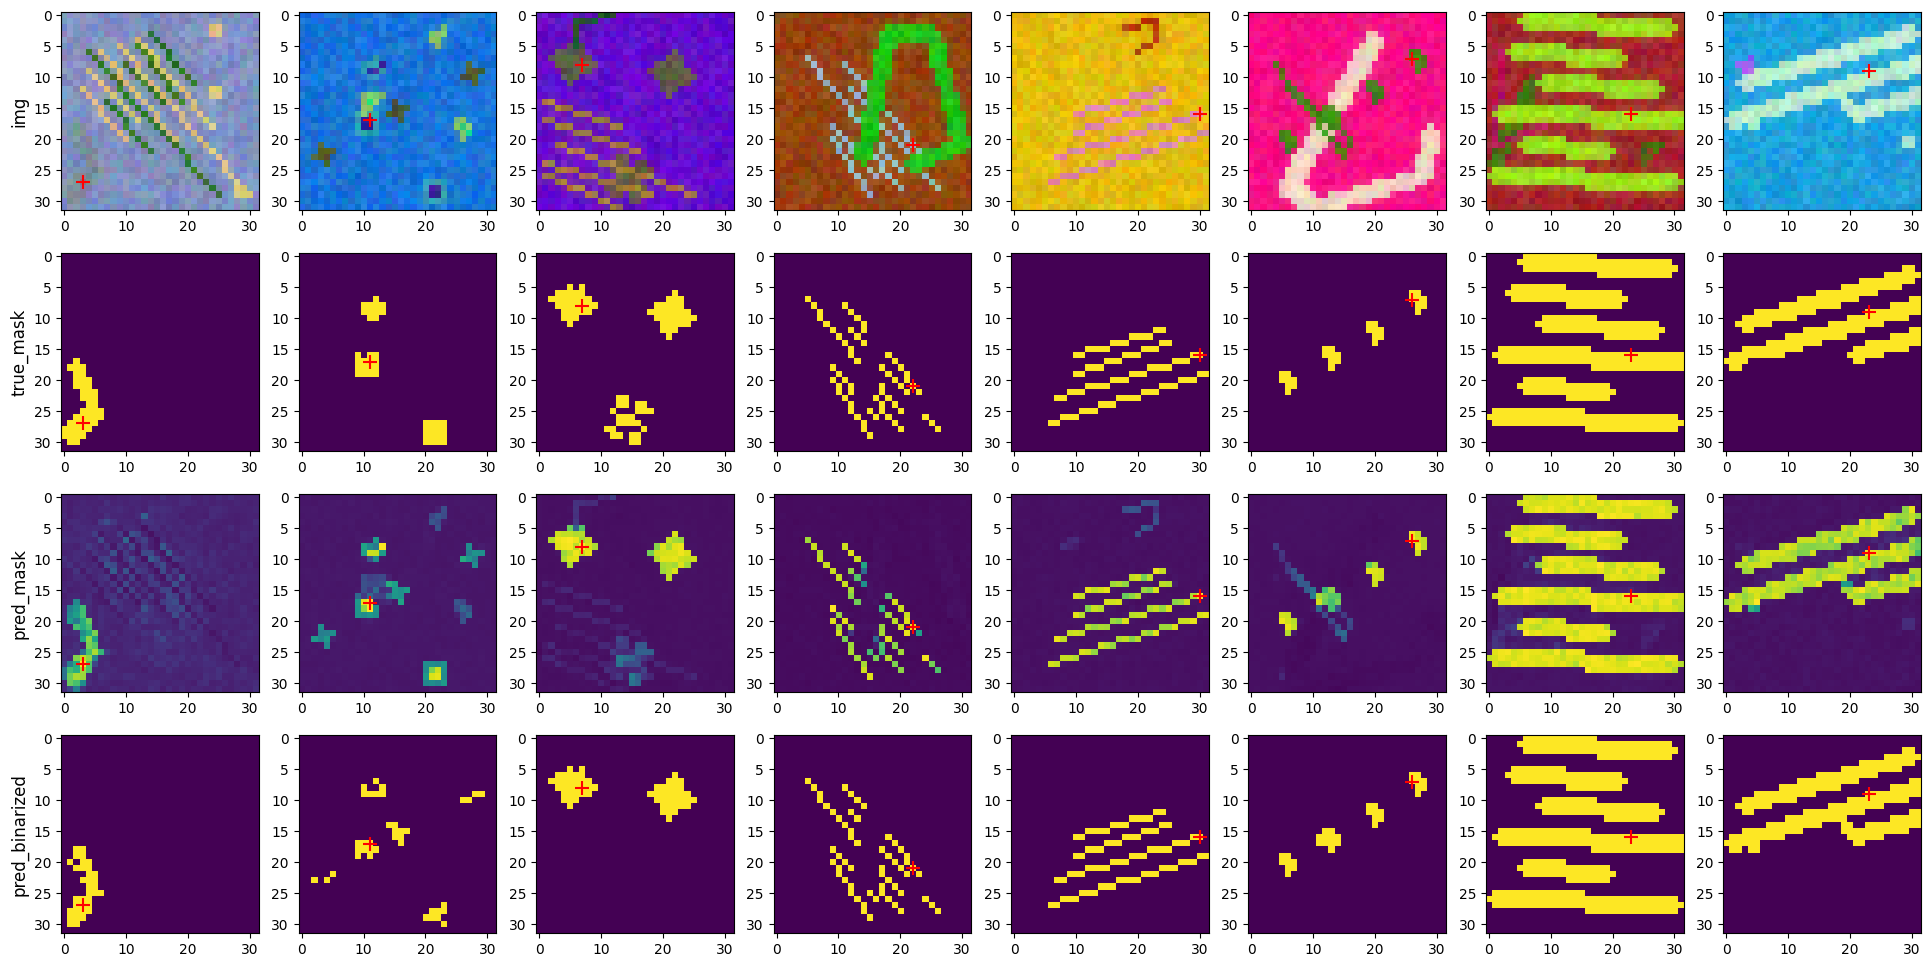

In [38]:
img, labels = next(test_iter)
s = len(img)
dot_labels = tf.squeeze(SqueezeImg()(labels), axis=-1)

pattern_labels = tf.reduce_sum(dot_labels[:,1:] + tf.random.uniform((s, dot_labels.shape[1]-1, 1), -0.5, 0.5), axis=1)
_, sample_points = tf.math.top_k(pattern_labels+tf.random.uniform(pattern_labels.shape, -0.1, 0.1), 1)
sample_points = sample_points[:,0]

dot_labels = tf.matmul(dot_labels, dot_labels, transpose_a=True)

preds = trainer.model(img, training=False)
#print(labels.shape, preds.shape)
print('total F1:', WeightedF12D()(dot_labels, preds).numpy())

#sample_points = tf.random.uniform((s,), 0, 32**2, dtype=tf.int32)
sample_labels = UnSqueezeImg()(tf.gather(dot_labels, sample_points[...,tf.newaxis], axis=1, batch_dims=1)[:,0,:,tf.newaxis])
sample_preds = UnSqueezeImg()(tf.gather(preds, sample_points[...,tf.newaxis], axis=1, batch_dims=1)[:,0,:,tf.newaxis])

print('weighted F1:', PixelSimilarityF1()(labels, preds).numpy())
print('sample F1:', WeightedF12D()(sample_labels, sample_preds).numpy())

bin_sample_preds = tf.where(sample_preds>0.5, 1, 0)

sample_points = decode1Dcoords(sample_points, 32)

#print(sample_labels.shape, sample_preds.shape, sample_points.shape)

fig, axs = plt.subplots(4, s, figsize=(s*3, 4*3))

for i in range(s):
    axs[0,i].imshow(img[i]) 
    axs[1,i].imshow(sample_labels[i], vmin=0, vmax=1)
    axs[2,i].imshow(sample_preds[i], vmin=0, vmax=1)
    axs[3,i].imshow(bin_sample_preds[i], vmin=0, vmax=1)

    for j in range(4):
        axs[j,i].scatter(*sample_points[i], marker='+', color='red', s=100)

    for i, title in enumerate(['img', 'true_mask', 'pred_mask', 'pred_binarized']):
        axs[i,0].set_ylabel(title, rotation=90, fontsize=12)